# Фреймворк PyTorch для разработки искусственных нейронных сетей

## Урок 2. CNN and LSTM for human action recognition

In [338]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import torchvision
import time
import math

from torchvision import datasets, transforms
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torch import optim
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [339]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True' # Для обхода бага библиотек

### 1.
Необходимо нормализовать данные в датасете: написать функцию нормализации и использовать ее внутри класса датасета

In [340]:
use_cuda = torch.cuda.is_available()
# device = torch.device("cpu")
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cuda


In [341]:
class Skeleton_Dataset(Dataset):
    def __init__(self, file_path, transform=None):
        self.data = pd.read_csv(file_path)
        self.transform = transform


    def __len__(self):
        return len(self.data) 
    
    
    def __getitem__(self, idx):
        item = np.asarray(self.data.iloc[idx,:-1]).reshape(45, 75)
        label = self.data.iloc[idx,-1]

        if self.transform != None:
            item = self.transform(item).numpy().reshape((45, 75))

        return (item, label) 

In [342]:
LABELS = {0: "cheer up", 1: "jump up", 2:  "hand waving", 3: "sitting down", 4: "clapping"}

In [343]:
#dataset = Skeleton_Dataset(file_path = "skels.csv", transform=None)

In [344]:
dataset = Skeleton_Dataset(file_path = "skels.csv", 
                           transform=transforms.Compose([
                               transforms.ToTensor(),
                               transforms.Normalize(mean=[0], std=[1]) # Нормализация
                           ]))

In [345]:
skel, lab = dataset.__getitem__(40)

In [346]:
LABELS[lab]

'hand waving'

In [347]:
skels_for_draw = skel.reshape(-1, 25, 3)

<IPython.core.display.Javascript object>


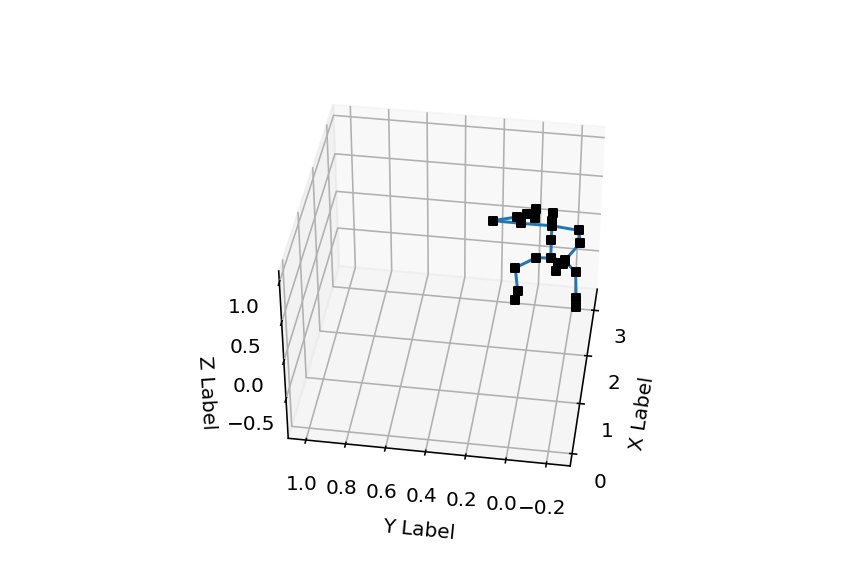

In [348]:
%matplotlib notebook

bone_pairs = (
    (1, 2), (2, 21), (3, 21), (4, 3), (5, 21), (6, 5),
    (7, 6), (8, 7), (9, 21), (10, 9), (11, 10), (12, 11),
    (13, 1), (14, 13), (15, 14), (16, 15), (17, 1), (18, 17),
    (19, 18), (20, 19), (22, 23), (21, 21), (23, 8), (24, 25),(25, 12)
)

i = 0
# for for_draw in skels_for_draw:
i = i + 1
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
for_draw = skels_for_draw[10]

for pair in bone_pairs:
    xs = for_draw[pair[0]-1][0], for_draw[pair[1]-1][0]
    ys = for_draw[pair[0]-1][1], for_draw[pair[1]-1][1]
    zs = for_draw[pair[0]-1][2], for_draw[pair[1]-1][2]

    line = plt3d.art3d.Line3D(zs, xs, ys)
    ax.add_line(line)


for x,y,z in for_draw:
    ax.scatter(z, x, y, color='black', marker='s')
    ax.set_xlabel('X Label')
    ax.set_ylabel('Y Label')
    ax.set_zlabel('Z Label')

    plt.show()

    #plt.savefig('pics_1/test_' +str(i)+'.png', bbox_inches='tight')
    #plt.clf()

### 2.
Дополнительное задание: http://archive.ics.uci.edu/ml/datasets/Individual+household+electric+power+consumption - 2075259 measurements gathered in a house located in Sceaux (7km of Paris, France) between December 2006 and November 2010 (47 months). Проделайте весь путь подготовки данных, создания датасета, разделения и обучения модели самостоятельно. Предсказывать нужно Global_active_power.

### 3.
https://drive.google.com/file/d/1rkpumcyjNRzLt4Fh_Qm2AZd8L-wnYS1z/view?usp=sharing

Приложен ноутбук в котором генерируется из большого датасета меньшая его копия. <br>
Вам нужно:<br>
Сгенерировать меньший датасет из 8-10 классов движения<br>
Изменить функцию разбиения датасета на тестовую и тренировочную часть, увеличив кусок, отводимый на тест<br>
Обучить уже существующую модель (предварительно проанализировав какие параметры нужно менять)<br>
Изменить модель для улучшения качества<br>
Сгенерировать другой датасет с меньшим количеством “кадром” в нашей серии и сравнить с улучшилось или ухудшилось качество предсказания.<br>
Провести несколько таких итераций, дать свою оценку уменьшению кадров, назвать оптимальное, на ваш взгляд, их количество.

In [349]:
data_path = "C:/Temp/nturgb+d_skeletons/"
broken_files_path = "NTU_RGBD_samples_with_missing_skeletons.txt"

In [350]:
training_subjects = list(range(0, 28)) #количество людей выполняющих действия
training_classes = [8, 9, 10] #классы которые будем использовать для обучения
training_cameras = [1, 2, 3]

max_body_true = 1
max_body_kinect = 1

num_joint = 25
max_frame = 300

In [351]:
def read_data(data_path, broken_files_path):
    labels = []
    files = []
    action_classes = {}
    counter = 0
    files_counter = {}
              
    with open(broken_files_path, 'r') as f:
        broken_files = f.read().split("\n")

    raw_files = os.listdir(data_path)
    num_frames = 0

    for filename in raw_files:
        if filename not in broken_files:
            action_class = int(filename[filename.find('A') + 1:filename.find('A') + 4])
            subject_id = int(filename[filename.find('P') + 1:filename.find('P') + 4])
            camera_id = int(filename[filename.find('C') + 1:filename.find('C') + 4])
            if action_class in training_classes and camera_id in training_cameras:  #and subject_id in training_subjects:
                if action_class in action_classes:
                    if files_counter[action_class] < 120:
                        files.append([filename,action_classes[action_class]])
                        files_counter[action_class] = files_counter[action_class] + 1
                else:
                    action_classes.update({action_class : counter})
                    files_counter.update({action_class : 1})
                    counter+=1
                    files.append([filename,action_classes[action_class]])
#                     labels.append([action_class])
    print("action classes: ", action_classes)
    print("action files: ", files_counter)
    
    return files, action_classes

In [352]:
def get_nonzero_std(s): 
    index = s.sum(-1).sum(-1) != 0  
    s = s[index]
    if len(s) != 0:
        s = s[:, :, 0].std() + s[:, :, 1].std() + s[:, :, 2].std()  
    else:
        s = 0
    return s

def read_skeleton_filter(file):
    with open(file, 'r') as f:
        skeleton_sequence = {}
        skeleton_sequence['numFrame'] = int(f.readline())
        skeleton_sequence['frameInfo'] = []
        for t in range(skeleton_sequence['numFrame']):
            frame_info = {}
            frame_info['numBody'] = int(f.readline())
            frame_info['bodyInfo'] = []

            for m in range(frame_info['numBody']):
                body_info = {}
                body_info_key = [
                    'bodyID', 'clipedEdges', 'handLeftConfidence',
                    'handLeftState', 'handRightConfidence', 'handRightState',
                    'isResticted', 'leanX', 'leanY', 'trackingState'
                ]
                body_info = {
                    k: float(v)
                    for k, v in zip(body_info_key, f.readline().split())
                }
                body_info['numJoint'] = int(f.readline())
                body_info['jointInfo'] = []
                for v in range(body_info['numJoint']):
                    joint_info_key = [
                        'x', 'y', 'z', 'depthX', 'depthY', 'colorX', 'colorY',
                        'orientationW', 'orientationX', 'orientationY',
                        'orientationZ', 'trackingState'
                    ]
                    joint_info = {
                        k: float(v)
                        for k, v in zip(joint_info_key, f.readline().split())
                    }
                    body_info['jointInfo'].append(joint_info)
                frame_info['bodyInfo'].append(body_info)
            skeleton_sequence['frameInfo'].append(frame_info)

    return skeleton_sequence

def read_xyz(file, max_body=1, num_joint=25):
    seq_info = read_skeleton_filter(file)
    data = np.zeros((max_body, seq_info['numFrame'], num_joint, 3))
    for n, f in enumerate(seq_info['frameInfo']):
        for m, b in enumerate(f['bodyInfo']):
            for j, v in enumerate(b['jointInfo']):
                if m < max_body and j < num_joint:
                    data[m, n, j, :] = [v['x'], v['y'], v['z']]

                else:
                    pass

    return data

In [353]:
def create_coords_blocks(test_file, chonk_len = 45):
    
    frame_counter = 0
    new_labels = []
    new_frames = []
    blocks = []
    
    test_frames = read_xyz(data_path + test_file[0])[0]
    label = test_file[1]
    slice_len = chonk_len * int(len(test_frames)/chonk_len)


    for index in range(len(test_frames[:slice_len])):
        frame_counter += 1
        new_frames.append(test_frames[index].flatten())
        if frame_counter == chonk_len:
            frame_counter = 0
            blocks.append(np.array(new_frames))
            new_labels = new_labels + [label]
            new_frames = []
       
            
    return blocks, new_labels

In [354]:
joints_framework = ['neck', 'nose', 'mid_hip',
                 'l_sho', 'l_elb',
                 'l_wri', 'l_hip',
                 'l_knee', 'l_ank',
                 'r_sho', 'r_elb',
                 'r_wri', 'r_hip',
                 'r_kne', 'r_ank',
                 'r_eye', 'l_eye',
                 'r_ear', 'l_ear']


joints_framework_in_work = ['nose','l_sho', 'l_elb','l_wri','r_sho','r_elb', 'r_wri', 'l_hip','l_knee','l_ank','r_hip','r_kne','r_ank','neck']
upper_joints_framework = ['nose','l_sho', 'l_elb','l_wri','r_sho','r_elb', 'r_wri', 'l_hip','l_knee','l_ank','r_hip','r_kne','r_ank','neck']



SKELETON_EDGES = np.array([[11, 10], [10, 9], [9, 0], [0, 3], [3, 4], [4, 5], [0, 6], [6, 7], [7, 8], [0, 12],
                               [12, 13], [13, 14], [1, 14], [1, 15], [15, 16], [1, 17], [17, 18]])

In [355]:
bone_pairs = (
    (1, 2), (2, 21), (3, 21), (4, 3), (5, 21), (6, 5),
    (7, 6), (8, 7), (9, 21), (10, 9), (11, 10), (12, 11),
    (13, 1), (14, 13), (15, 14), (16, 15), (17, 1), (18, 17),
    (19, 18), (20, 19), (22, 23), (21, 21), (23, 8), (24, 25),(25, 12)
)

bone_pairs_in_work = (
    (1, 14), 
    (14, 2), (2, 3), (3, 4),
    (14, 5), (5, 6), (6, 7), 
    (14, 8), (8, 9), (9, 10),
    (14, 11), (11, 12), (12, 13))


joints_names = ['spinebase', 'spinemid', 'neck', 'head','l_sho', 'l_elb','l_wri','l_hand','r_sho','r_elb', 'r_wri', 'r_hand','l_hip','l_knee','l_ank','l_fool','r_hip','r_knee','r_ank','r_foot','spineshoulder','l_tip','l_thumb','r_tip','r_thunb']
joints_in_work = [ 'head','l_sho', 'l_elb','l_wri','r_sho','r_elb', 'r_wri', 'l_hip','l_knee','l_ank','r_hip','r_knee','r_ank','spineshoulder']
upper_joints = [ 'head','l_sho', 'l_elb','l_wri','r_sho','r_elb', 'r_wri', 'l_hip','l_knee','l_ank','r_hip','r_knee','r_ank','spineshoulder']

In [356]:
##### список файлов с лейблами на каждый файл 
working_files_with_labels, action_classes = read_data(data_path, broken_files_path)

action classes:  {8: 0, 9: 1, 10: 2}
action files:  {8: 120, 9: 120, 10: 120}


In [357]:
LABELS = {v: k for k, v in action_classes.items()}

In [358]:
print(LABELS)

{0: 8, 1: 9, 2: 10}


In [359]:
len(working_files_with_labels)

360

In [360]:
data = []
labels = []
##########################################################################
numbers = {0: 0, 1 : 0, 2 : 0, 3 : 0, 4 :0} #####
##################################################################
for file in working_files_with_labels:
    frames_blocks, label = create_coords_blocks(file)
    if label != [] and numbers[label[0]] <= 150:
        numbers[label[0]] = numbers[label[0]] + len(label)
        data = data + frames_blocks
        labels = labels + label
data_np = np.asarray(data)
labels_np = np.asarray(labels)

data_sq = data_np.reshape(len(data_np), -1)
test_data = pd.DataFrame(data_sq)
test_labels = pd.DataFrame(labels_np)
test_data['labels'] = test_labels

In [361]:
test_data.to_csv("test_01.csv", index = False)

### Обучение

In [362]:
dataset = Skeleton_Dataset(file_path = "test_01.csv", 
                           transform=transforms.Compose([
                               transforms.ToTensor(),
                               transforms.Normalize(mean=[0], std=[1]) # Нормализация
                           ]))

In [363]:
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [int(0.7*len(dataset)),int(0.3*len(dataset))+1])
train_loader = DataLoader(train_dataset, batch_size = 16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size = 16, shuffle=True)

In [364]:
n_hidden = 128
n_joints = 25*3
n_categories = len(LABELS)
n_layer = 2
rnn = LSTM_net(n_joints,n_hidden,n_categories,n_layer)
rnn.to(device)

LSTM_net(
  (lstm): LSTM(75, 128, num_layers=2, batch_first=True)
  (fc): Linear(in_features=128, out_features=3, bias=True)
)

In [365]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return LABELS[category_i], category_i

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [366]:
criterion = nn.CrossEntropyLoss()
learning_rate = 0.0007
optimizer = optim.SGD(rnn.parameters(),lr=learning_rate,momentum=0.9)

all_losses = []
start = time.time()
counter = 0
for epoch in range(800):  
    current_loss = 0
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        
        inputs, labels = data[0].to(device), data[1].to(device)
    
        optimizer.zero_grad()
    
        output = rnn(inputs.float())
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step() 


        current_loss += loss.item()
        category = LABELS[int(labels[0])]

        if counter % 500 == 0:
            guess, guess_i = categoryFromOutput(output)
            correct = '✓' if guess == category else '✗ (%s)' % category
            #####сделать более аккуратный вывод для каждой эпохии
            ######сделать обновление графика loss по ходу обучению  
            print('epoch : %d iter : %d (%s) %.4f  / %s %s' % (epoch, i, timeSince(start), loss, guess, correct))

        
        counter = counter + 1
    if counter % 100 == 0:
        all_losses.append(current_loss / 25)
        current_loss = 0
    

epoch : 0 iter : 0 (0m 0s) 1.1026  / 10 ✗ (9)
epoch : 27 iter : 14 (0m 13s) 1.0137  / 8 ✓
epoch : 55 iter : 10 (0m 26s) 0.5596  / 8 ✗ (9)
epoch : 83 iter : 6 (0m 40s) 0.3833  / 10 ✓
epoch : 111 iter : 2 (0m 53s) 0.4955  / 10 ✓
epoch : 138 iter : 16 (1m 6s) 0.4906  / 10 ✓
epoch : 166 iter : 12 (1m 19s) 0.3490  / 10 ✓
epoch : 194 iter : 8 (1m 33s) 0.3116  / 10 ✗ (8)
epoch : 222 iter : 4 (1m 46s) 0.2063  / 10 ✓
epoch : 250 iter : 0 (1m 59s) 0.2708  / 10 ✓
epoch : 277 iter : 14 (2m 12s) 0.3736  / 10 ✓
epoch : 305 iter : 10 (2m 26s) 0.1294  / 9 ✓
epoch : 333 iter : 6 (2m 39s) 0.1025  / 9 ✓
epoch : 361 iter : 2 (2m 52s) 0.0285  / 9 ✓
epoch : 388 iter : 16 (3m 4s) 0.1660  / 8 ✓
epoch : 416 iter : 12 (3m 17s) 0.1880  / 9 ✓
epoch : 444 iter : 8 (3m 30s) 0.0832  / 10 ✓
epoch : 472 iter : 4 (3m 43s) 0.1682  / 8 ✓
epoch : 500 iter : 0 (3m 56s) 0.0720  / 8 ✓
epoch : 527 iter : 14 (4m 9s) 0.1594  / 10 ✓
epoch : 555 iter : 10 (4m 22s) 0.1703  / 8 ✓
epoch : 583 iter : 6 (4m 35s) 0.0155  / 9 ✓
epoch : 

In [367]:
%matplotlib notebook
plt.plot(list(range(0,len(all_losses))),all_losses)
plt.show()

<IPython.core.display.Javascript object>

In [368]:
total = 0
right = 0
counter = 0
with torch.no_grad():
    for i, data in enumerate(test_loader, 0):
        counter = counter + 1
        inputs, labels = data[0].to(device), data[1].to(device)   
        output = rnn(inputs.float())
        guess, guess_i = categoryFromOutput(output)
        category = LABELS[int(labels[0])]
        
        if guess == category:
            right = right + 1


print('Accuracy of the network:  ',  (100 * right / counter))

Accuracy of the network:   87.5


### Проверим на разном количестве кадров

In [374]:
class Skeleton_Dataset(Dataset):
    def __init__(self, file_path, transform=None, frame=45):
        self.data = pd.read_csv(file_path)
        self.transform = transform


    def __len__(self):
        return len(self.data) 
    
    
    def __getitem__(self, idx):
        item = np.asarray(self.data.iloc[idx,:-1]).reshape(frame, 75)
        label = self.data.iloc[idx,-1]

        if self.transform != None:
            item = self.transform(item).numpy().reshape((frame, 75))

        return (item, label) 

In [375]:
for frame in [10, 20, 30, 40]:
    data = []
    labels = []
    ##########################################################################
    numbers = {0: 0, 1 : 0, 2 : 0, 3 : 0, 4 :0} #####
    ##################################################################
    for file in working_files_with_labels:
        frames_blocks, label = create_coords_blocks(file, chonk_len = frame)
        if label != [] and numbers[label[0]] <= 150:
            numbers[label[0]] = numbers[label[0]] + len(label)
            data = data + frames_blocks
            labels = labels + label
    data_np = np.asarray(data)
    labels_np = np.asarray(labels)

    data_sq = data_np.reshape(len(data_np), -1)
    test_data = pd.DataFrame(data_sq)
    test_labels = pd.DataFrame(labels_np)
    test_data['labels'] = test_labels
    
    dataset = Skeleton_Dataset(file_path = "test_xx.csv", 
                               transform=transforms.Compose([
                                   transforms.ToTensor(),
                                   transforms.Normalize(mean=[0], std=[1]) # Нормализация
                               ]),
                               frame=frame
                              )    
    
    tr = int(0.7*len(dataset))
    ts = len(dataset) - tr
    train_dataset, test_dataset = torch.utils.data.random_split(dataset, [tr, ts])
    train_loader = DataLoader(train_dataset, batch_size = 16, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size = 16, shuffle=True)
    
    n_hidden = 128
    n_joints = 25*3
    n_categories = len(LABELS)
    n_layer = 2
    rnn = LSTM_net(n_joints,n_hidden,n_categories,n_layer)
    rnn.to(device)    

    criterion = nn.CrossEntropyLoss()
    learning_rate = 0.0007
    optimizer = optim.SGD(rnn.parameters(),lr=learning_rate,momentum=0.9)

    all_losses = []
    start = time.time()
    counter = 0
    for epoch in range(800):  
        current_loss = 0
        running_loss = 0.0
        for i, data in enumerate(train_loader, 0):

            inputs, labels = data[0].to(device), data[1].to(device)

            optimizer.zero_grad()

            output = rnn(inputs.float())
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step() 

            current_loss += loss.item()
            category = LABELS[int(labels[0])]

            if counter % 500 == 0:
                guess, guess_i = categoryFromOutput(output)
                correct = '✓' if guess == category else '✗ (%s)' % category
                #####сделать более аккуратный вывод для каждой эпохии
                ######сделать обновление графика loss по ходу обучению  
                print('epoch : %d iter : %d (%s) %.4f  / %s %s' % (epoch, i, timeSince(start), loss, guess, correct))

            counter = counter + 1
        if counter % 100 == 0:
            all_losses.append(current_loss / 25)
            current_loss = 0

            
    total = 0
    right = 0
    counter = 0
    with torch.no_grad():
        for i, data in enumerate(test_loader, 0):
            counter = counter + 1
            inputs, labels = data[0].to(device), data[1].to(device)   
            output = rnn(inputs.float())
            guess, guess_i = categoryFromOutput(output)
            category = LABELS[int(labels[0])]

            if guess == category:
                right = right + 1


    print(f'При { frame } кадров точность :  { (100 * right / counter) }')

epoch : 0 iter : 0 (0m 0s) 1.1135  / 9 ✗ (8)
epoch : 25 iter : 0 (0m 5s) 1.0885  / 8 ✗ (9)
epoch : 50 iter : 0 (0m 10s) 0.8814  / 8 ✓
epoch : 75 iter : 0 (0m 15s) 0.5747  / 8 ✓
epoch : 100 iter : 0 (0m 20s) 0.7803  / 8 ✓
epoch : 125 iter : 0 (0m 26s) 0.6919  / 8 ✗ (9)
epoch : 150 iter : 0 (0m 31s) 0.6020  / 10 ✓
epoch : 175 iter : 0 (0m 37s) 0.5819  / 10 ✓
epoch : 200 iter : 0 (0m 42s) 0.6884  / 9 ✗ (10)
epoch : 225 iter : 0 (0m 47s) 0.6261  / 10 ✓
epoch : 250 iter : 0 (0m 53s) 0.6041  / 8 ✗ (9)
epoch : 275 iter : 0 (0m 58s) 0.9103  / 8 ✗ (9)
epoch : 300 iter : 0 (1m 3s) 0.5810  / 8 ✓
epoch : 325 iter : 0 (1m 9s) 0.4353  / 8 ✓
epoch : 350 iter : 0 (1m 14s) 0.6244  / 8 ✓
epoch : 375 iter : 0 (1m 19s) 0.4166  / 8 ✓
epoch : 400 iter : 0 (1m 25s) 0.4285  / 9 ✓
epoch : 425 iter : 0 (1m 30s) 0.7992  / 9 ✓
epoch : 450 iter : 0 (1m 35s) 0.6717  / 9 ✓
epoch : 475 iter : 0 (1m 40s) 0.6582  / 10 ✓
epoch : 500 iter : 0 (1m 46s) 0.4701  / 8 ✗ (9)
epoch : 525 iter : 0 (1m 51s) 0.7445  / 8 ✗ (9)
epoc

Для данного датасета оптимальным будет частота в районе 40 кадров.